In [1]:
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


/Users/r/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [6]:

OHLCV = ['open', 'high', 'low', 'close', 'volume']

class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())
    
    
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None


    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))  

        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('PnL, profit %.2f, net profit %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                self.buy()
                
            if self.data_predicted < 0:
                self.sell()
                
           
        if self.position:
            if self.position.size > 0 and self.data_predicted < 0:
                self.close()
                self.sell()
            
            if self.position.size > 0 and self.data_predicted == 0:
                self.close()
            
            if self.position.size < 0 and self.data_predicted > 0:
                self.close()
                self.buy()
                
            if self.position.size < 0 and self.data_predicted == 0:
                self.close()
    

In [7]:
from datetime import datetime

prices = pd.read_csv('/Users/r/Desktop/HFT project1/prices4.csv')
ticker = 'ES'
prices['Date'] = pd.to_datetime(prices['Date'], format = "%d/%m/%Y" )
prices.set_index('Date', inplace=True)  

print(prices)

data = SignalData(dataname=prices)


cerebro = bt.Cerebro(cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.addsizer(bt.sizers.SizerFix, stake=50)
cerebro.broker.setcash(1000000.0)
cerebro.broker.setcommission(commission=0.025, margin=True)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')



               open     high      low    close  volume  predicted
Date                                                             
2022-01-02  4772.25  4772.25  4772.25  4772.25       0          0
2022-01-02  4772.00  4772.00  4772.00  4772.00       0          0
2022-01-02  4772.00  4772.00  4772.00  4772.00       0         -1
2022-01-02  4771.75  4771.75  4771.75  4771.75       0          0
2022-01-02  4771.75  4771.75  4771.75  4771.75       0          0
...             ...      ...      ...      ...     ...        ...
2022-01-31  4431.50  4431.50  4431.50  4431.50       0         -1
2022-01-31  4431.00  4431.00  4431.00  4431.00       0         -1
2022-01-31  4431.25  4431.25  4431.25  4431.25       0         -1
2022-01-31  4431.25  4431.25  4431.25  4431.25       0         -1
2022-01-31  4431.50  4431.50  4431.50  4431.50       0          0

[1048375 rows x 6 columns]


In [8]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

backtest_result = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 1000000.00
2022-01-02, PnL, profit 12.50, net profit 10.00
2022-01-02, PnL, profit 25.00, net profit 22.50
2022-01-02, PnL, profit 12.50, net profit 10.00
2022-01-02, PnL, profit 0.00, net profit -2.50
2022-01-02, PnL, profit 12.50, net profit 10.00
2022-01-02, PnL, profit 0.00, net profit -2.50
2022-01-02, PnL, profit 12.50, net profit 10.00
2022-01-02, PnL, profit -25.00, net profit -27.50
2022-01-02, PnL, profit 12.50, net profit 10.00
2022-01-02, PnL, profit 12.50, net profit 10.00
2022-01-02, PnL, profit -12.50, net profit -15.00
2022-01-02, PnL, profit 0.00, net profit -2.50
2022-01-02, PnL, profit -12.50, net profit -15.00
2022-01-02, PnL, profit 0.00, net profit -2.50
2022-01-02, PnL, profit -12.50, net profit -15.00
2022-01-02, PnL, profit 12.50, net profit 10.00
2022-01-02, PnL, profit 12.50, net profit 10.00
2022-01-02, PnL, profit -12.50, net profit -15.00
2022-01-02, PnL, profit 12.50, net profit 10.00
2022-01-02, PnL, profit 12.50, net profit 10.

2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 37.50, net profit 35.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -37.50, net profit -40.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -62.50, net profit -65.00
2022-01-03, PnL, profit -25.00, net profit -27.50
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit -25.00, net profit -27.50
2022-01-03, PnL, profit 25.00, net profit 22.50
2022-01-03, PnL, profit -25.00, net profit -27.50
2022-01-03, PnL, profit -25.00, 

2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 37.50, net profit 35.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit -25.00, net profit -27.50
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 25.00, net profit 22.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -25.00, net profit -27.50
2022-01-03, PnL, prof

2022-01-03, PnL, profit -25.00, net profit -27.50
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 62.50, net profit 60.00
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -25.00, net profit -27.50
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 25.00, net profit 22.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -25.00, net profit -27.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 12.50, net

2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 50.00, net profit 47.50
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 37.50, net profit 35.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.5

2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 25.00, net profit 22.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 62.50, net profit 60.00
2022-01-03, PnL, profit 0.00, net profit -2.50
2022-01-03, PnL, profit 12.50, net profit 10.00
2022-01-03, PnL, profit -12.50, net profit -15.00
2022-01-03, PnL, profit -12.50, net profit -15

2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 37.50, net profit 35.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 25.00, net profit 22.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 25.00, net profit 22.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit -12.50, net profit -15.00
202

2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit -25.00, net profit -27.50
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit -25.00, net profit -27.50
2022-01-04, PnL, profit -25.00, net profit -27.50
2022-01-04, PnL, profit 50.00, net profit 47.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 25.00, net profit 22.50
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit -12.50, ne

2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit 62.50, net profit 60.00
2022-01-04, PnL, profit 37.50, net profit 35.00
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 25.00, net profit 22.50
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit 62.50, net profit 60.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 37.50, net profit 35.00
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 12.50, net prof

2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 37.50, net profit 35.00
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit 25.00, net profit 22.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit -12.50, net profit 

2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit -12.50, net profit -15.00
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-04, PnL, profit 12.50, net profit 10.00
2022-01-04, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 37.50, net profit 35.00
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 0.00, net profit -2.50


2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 0.00, net profit

2022-01-05, PnL, profit 100.00, net profit 97.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 62.50, net profit 60.00
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 175.00, net profit 172.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 50.00, net profit 47.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 37.50, net profit 35.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 12.50, net profi

2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 37.50, net profit 35.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 37.50, net profit 35.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 25.00, net profi

2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2

2022-01-05, PnL, profit -37.50, net profit -40.00
2022-01-05, PnL, profit 212.50, net profit 210.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 87.50, net profit 85.00
2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit -37.50, net profit -40.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit -50.00, net profit -52.50
2022-01-05, PnL, profit -37.50, net profit -40.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit -37.50, net profit -40.00
2022-01-05, PnL, profit 62.50, net profit 60.00
2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, Pn

2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -50.00, net profit -52.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit -37.50, net profit -40.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 37.50, net profit 35.00
2022-01-05, PnL, profit 50.00, net profit 47.50
2022-01-05, PnL, pro

2022-01-05, PnL, profit 50.00, net profit 47.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 50.00, net profit 47.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit 37.50, net profit 35.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 75.00, net profit 72.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit -25.00, net profit -27.50
2022-01-05, PnL, profit 37.50, ne

2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 75.00, net profit 72.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -37.50, net profit -40.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -62.50, net profit -65.00
2022-01-05, PnL, profit 37.50, net profit 35.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 50.00, net profit 47.50
2022-01-05, PnL, profit 0.00, net pr

2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 25.00, net profit 22.50
2022-01-05, PnL, profit 37.50, net profit 35.00
2022-01-05, PnL, profit 50.00, net profit 47.50
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 12.50, net profit 10.00
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit 0.00, net profit -2.50
2022-01-05, PnL, profit -12.50, net profit -15.00
2022-01-05, PnL, profit 12.50, net pr

2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 37.50, net profit 

2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net profit

2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 62.50, net profit 60.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net profi

2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit

2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.

2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 12.50, net profit 10

2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 87.50, net profit 85.00
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit -37.50, net profit -40.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit 

2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -50.00, net profit -52.50
2022-01-06, PnL, profit 125.00, net profit 122.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -50.00, net profit -52.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -50.00, net profit -52.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, prof

2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit -37.50, net profit -40.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -50.00, net profit -52.50
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit 37

2022-01-06, PnL, profit -50.00, net profit -52.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 75.00, net profit 72.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 75.00, net profit 72.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net

2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 100.00, net profit 97.50
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -25.00, net 

2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net pr

2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 100.00, net profit 97.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net

2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 62.50, net profit 60.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net p

2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 37.50, net profit 35.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.50, net profit -15.0

2022-01-06, PnL, profit -87.50, net profit -90.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 12.50, net profit 10.00
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit 25.00, net profit 22.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -25.00, net profit -27.50
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit -12.50, net profit -15.00
2022-01-06, PnL, profit 50.00, net profit 47.50
2022-01-06, PnL, profit 0.00, net profit -2.50
2022-01-06, PnL, profit -12.5

2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 62.50, net profit 60.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 0.00, net profit

2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 12.50, net pro

2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 50.00, net profit 47.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 87.50, net profit 85.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 25.00, net

2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 50.00, net profit 47.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit -12.50, net profit 

2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 75.00, net profit 72.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 62.50, net profit 60.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 62.50, net profit 60.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit -37.50, net profit -40.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 12.50,

2022-01-07, PnL, profit 87.50, net profit 85.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit 62.50, net profit 60.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 62.50, net profit 60.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 12.5

2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -37.50, net profit -40.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 50.00, net profit 47.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.5

2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 50.00, net profit 47.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 50.00, net profit 47.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.5

2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 50.00, net profit 47.50
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 50.00, net profit 47.50
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, n

2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 50.00, net profit 47.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit -37.50, net profit -40.00
2022-01-07, PnL, profit 0.00, net pro

2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit 

2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 37.50, net profit 35.00
2022-01-07, PnL, profit 50.00, net profit 47.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 87.50, net profit 85.00
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 25.00, net profit 22.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -25.00, net profit -27.50
2022-01-07, PnL, profit 0.00, net profit -2.50
2022-01-07, PnL, profit -12.50, net profit -15.00
2022-01-07, PnL, profit 12.50, net profit 10.00
2022-01-07, PnL, profit 0.00, net profi

2022-01-09, PnL, profit -12.50, net profit -15.00
2022-01-09, PnL, profit -12.50, net profit -15.00
2022-01-09, PnL, profit 0.00, net profit -2.50
2022-01-09, PnL, profit 75.00, net profit 72.50
2022-01-09, PnL, profit 12.50, net profit 10.00
2022-01-09, PnL, profit 12.50, net profit 10.00
2022-01-09, PnL, profit 0.00, net profit -2.50
2022-01-09, PnL, profit -12.50, net profit -15.00
2022-01-09, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 50.00, net profit 47.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.

2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 37.50, net prof

2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 87.50, net profit 85.00
2022-01-10, PnL, profit 62.50, net profit 60.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 37.50, net profi

2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.

2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 50.00, net profit 47.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50

2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit -50.00, net profit -52.50
2022-01-10, PnL, profit 50.00, net profit 47.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -37.50, net profit -40.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit -37.50, net profit -40.00
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 50.00, net profit 47.50
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit -37.50, net profit -40.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -

2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 62.50, net profit 60.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 37.50

2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -62.50, net profit -65.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 87.50, net profit 85.00
2022-01-10, PnL, profit 75.00, net profit 72.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 62.50, net profit 60.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -37.50, net profit -40.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net

2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit 75.00, net profit 72.50
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit 75.00, net profit 72.50
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit -50.00, net profit -52.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -

2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 62.50, net profit 60.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, pr

2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 162.50, net profit 160.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -75.00, net profit -77.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit 87.50, net 

2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -25.

2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 50.00, net profit 47.50
2022-01-10, PnL, profit 37.50, net profit 35.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit -37.50, net profit -40.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 0.00, net profit -2.50
2022-01-10, PnL, profit -12.50

2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 62.50, net profit 60.00
2022-01-10, PnL, profit -50.00, net profit -52.50
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, PnL, profit -37.50, net profit -40.00
2022-01-10, PnL, profit -87.50, net profit -90.00
2022-01-10, PnL, profit -50.00, net profit -52.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 62.50, net profit 60.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit -12.50, net profit -15.00
2022-01-10, PnL, profit 25.00, net profit 22.50
2022-01-10, PnL, profit 12.50, net profit 10.00
2022-01-10, PnL, profit -25.00, net profit -27.50
2022-01-10, Pn

2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.0

2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 0.00, net profi

2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit -12.50, net prof

2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 50.00, net profit 47.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 62.50, net profit 60.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 62.50, net profit 60.00
2022-01-11, PnL, profit 0.00, net pro

2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net 

2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00

2022-01-11, PnL, profit 50.00, net profit 47.50
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit -37.50, net profit -40.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 50.00, net profit 47.50
2022-01-11, PnL, profit 125.00, net profit 122.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -37.50, net profit -40.00
2022-01-11, PnL, profit -50.00, net profit -52.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit -37.50, net profit -40.00
2022-01-11, PnL, profit -37.50, net profit -40.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -37.50, net profit -40.00
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, prof

2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 50.00, net profit 47.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 62.50, net profit 60.00
2022-01-11, PnL, profit 200.00, net profit 197.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit -12.50, ne

2022-01-11, PnL, profit -37.50, net profit -40.00
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 87.50, net profit 85.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 100.00, net profit 97.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit -100.00, net profit -102.50
2022-01-11, PnL, profit -37.50, net profit -40.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit -50.00, net profit -52.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, pr

2022-01-11, PnL, profit 225.00, net profit 222.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 62.50, net profit 60.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit -37.50, net profit -40.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net p

2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -25.00, net profit -27.50
2022-01-11, PnL, profit 50.00, net profit 47.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -37.50, net profit -40.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 25.00, net 

2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 75.00, net profit 72.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit 25.00, net profit 22.50


2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit -12.50, net profit -15.00
2022-01-11, PnL, profit 0.00, net profit -2.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 37.50, net profit 35.00
2022-01-11, PnL, profit 25.00, net profit 22.50
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profit 10.00
2022-01-11, PnL, profit 12.50, net profi

2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 37.50, net profit 35.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 75.00, net profit 72.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net pro

2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 50.00, net profit 47.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 37.50, net profit 35.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net pro

2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 37.50, net profit 35.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 37.50, net profit 35.00
2022-01-12, PnL, profit 37.50, net profit 35.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 37.50, net profit 35.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.5

2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 37.50, net profit 35.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -

2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 75.00, net profit 72.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 50.00, net profit 47.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50

2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 50.00, net profit 47.50
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 37.50, net profit 35.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -25.00, net profit -27.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -50.00, net profit -52.50
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit -37.50, net profit -40.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profi

2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -25.00, net profit -27.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit -25.00, net profit -27.50
2022-01-12, PnL, pro

2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit -25.00, net profit -27.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 62.50, net profit 60.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 62.50, net profit

2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 12.50, net profit 1

2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit -25.00, net profit -27.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit -25.00, net profit -27.50
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit -12.50, net profit -15.00
2022-01-12, PnL, profit 62.50, net profit 60.00
2022-01-12, PnL, profit 12.50, net profit 10.00
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 25.00, net profit 22.50
2022-01-12, PnL, profit 0.00, net profit -2.50
2022-01-12, PnL, profit 0.00, net p

2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 12.50, net 

2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 62.50, net profit 60.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit 

2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 50.00, net profit 47.50
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 87.50, net profit 85.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 37.50, net profit 35.00
2022-01-13, PnL, profit 62.50, net profit 60.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 37.50, net profit 35.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profi

2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 87.50, net profit 85.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 37.50, net profit 35.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 37.50, net profit 35.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit 0.00, net prof

2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 25.00, n

2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 50.00, net profit 47.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net 

2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -37.50, net profit -40.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 1

2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 37.50, net profit 35.00
2022-01-13, PnL, profit 37.50, net profit 35.00
2022-01-13, PnL, profit 37.50, net profit 35.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 37.50, net profit 35.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -37.50, ne

2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net pro

2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 75.00, net profit 72.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit 87.50, net profit 85.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, n

2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 25.00, net profit 22.50
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 12.50, net profit 10.00
2022-01-13, PnL, profit 37.50, net profit 35.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit -37.50, net profit -40.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -25.00, net profit -27.50
2022-01-13, PnL, profit -62.50, net profit -65.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit -12.50, net profit -15.00
2022-01-13, PnL, profit 0.00, net profit -2.50
2022-01-13, PnL, profit 

2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profi

2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 87.50, net profit 85.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2

2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 87.50, net profit 85.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit -25.00, net profit -27.50

2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 75.00, net profit 72.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 62.50, net profit 60.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit -37.50, net profit -40.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 50.00, net profit 47.50
2022-01-14, PnL, profit -12.50, net 

2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.5

2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profi

2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -62.50, net p

2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit -50.00, net profit -52.50
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -37.50, net profit -40.00
2022-01-14, PnL, profit 0.00,

2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 75.00, net profit 72.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 100.00, net profit 97.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 100.00, net profit 97.50
2022-01-14, PnL, profit 112.50, net profit 110.00
2022-01-14, PnL, profit 62.50, net profit 60.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, 

2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 75.00, net profit 72.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 62.50, net profit 60.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 125.00, net profit 122.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -12.5

2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 100.00, net profit 97.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -37.50, net profit -40.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -37.50, net profit -40.00
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit -50.00, net profit -52.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 62.50, net profit 60.00
2022-01-14, PnL, profit 50.00, n

2022-01-14, PnL, profit -62.50, net profit -65.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -37.50, net profit -40.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 50.00, net profit 47.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 50.00, net profit 47.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profi

2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15

2022-01-14, PnL, profit 50.00, net profit 47.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 125.00, net profit 122.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 62.50, net profit 60.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net 

2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 100.00, net profit 97.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 62.50, net profit 60.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 87.50, net profit 85.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit -37.50, net profit -40.00
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 1

2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 125.00, net profit 122.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 37.50, net profit 35.00
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -25.00, net profit -27.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 87.50, net profit 85.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net pr

2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 62.50, net profit 60.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 62.50, net profit 60.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 50.00, net profit 47.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 25.00, 

2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 12.50, net profit 10.00
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit 0.00, net profit -2.50
2022-01-14, PnL, profit -12.50, net profit -15.00
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-14, PnL, profit 25.00, net profit 22.50
2022-01-16, PnL, profit 75.00, net profit 72.50
2022-01-16, PnL, profit 187.50, net profit 185.00
2022-01-16, PnL, profit 37.50, net profit 35.00
2022-01-16, PnL, profit -12.50, net profit -15.00
2022-01-16, PnL, profit 0.00, net profit -2.50
2022-01-16, PnL, profit 62.50, net profit 60.00
2022-01-16, PnL, profit 12.50, net profit 10.00
2022-01-16, PnL, profit 0.00, net profit -2.50
2022-01-16, PnL, profit 0.00, net profi

2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 37.50, net profit 35.00
2022-01-17, PnL, profit 25.00, net profit 22.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit -12.50, net profit -15.00
2022-01-17, PnL, profit 25.00, net profit 22.50
2022-01-17, PnL, profit -25.00, net profit -27.50
2022-01-17, PnL, profit 25.00, net profit 22.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 62.50, net pro

2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit -12.50, net profit -15.00
2022-01-17, PnL, profit 37.50, net profit 35.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 37.50, net profit 35.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit -12.50, net profit -15.00
2

2022-01-17, PnL, profit -25.00, net profit -27.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit -12.50, net profit -15.00
2022-01-17, PnL, profit -12.50, net profit -15.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 25.00, net profit 22.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit -12.50, net profit -15.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit 

2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit -12.50, net profit -15.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit -12.50, net profit -15.00
2022-01-17, PnL, profit 25.00, net profit 22.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 25.00, net profit 22.50
2022-01-17, PnL, profit 12.50, net profit 10.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 37.50, net profit 35.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit -12.50, net profit -15.00
2022-01-17, PnL, profit 0.00, net profit -2.50
2022-01-17, PnL, profit 0.00, net profit -2

2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 37.50, net profit 35.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net prof

2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net prof

2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 37.50, net profit 35.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 37.50, net profit 35.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -

2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 87.50, net profit 85.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profi

2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 37.50, net 

2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 37.50, net profit 35.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 50.00, net profit 47.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 2

2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -37.50, net profit -40.00
2022-01-18, PnL, profit 100.00, net profit 97.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -37.50, net profit -40.00
2022-01-18, PnL, profit 50.00, net profit 47.50
2022-01-18, PnL, profit 12.50, net prof

2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 75.00, net profit 72.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit -100.00, net profit -102.50
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit -37.50, net profit -40.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit -62.50, net profit -65.00
2022-01-18, PnL, profit -75.00, net profit -77.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, p

2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -37.50, net profit -40.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -37.50, net profit -40.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 37.50, net profit 35.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 37.50, net profit 35.00
2022-01-18, PnL, profit 12.50, 

2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profi

2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 100.00, net profit 97.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 

2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 75.00, net profit 72.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net p

2022-01-18, PnL, profit 75.00, net profit 72.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00

2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 50.00, net profit 47.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 37.50, net profit 35.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 12.50, net profit 

2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit -37.50, net profit -40.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 50.00, net profit 47.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 75.00, n

2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 50.00, net profit 47.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit -12.50, net profit -15.00
2022-01-18, PnL, profit 125.00, net profit 122.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 25.00, net profit 22.50
2022-01-18, PnL, profit 12.50, net profit 10.00
2022-01-18, PnL, profit 0.00, net profit -2.50
2022-01-18, PnL, profit 162.50, net profit 160.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit -37.50, net profit -40.00
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit -25.00, net profit -27.50
2022-01-18, PnL, profit 87.50, net profit 85.00
2022-01-18, PnL, profit 0.00, ne

2022-01-19, PnL, profit 50.00, net profit 47.50
2022-01-19, PnL, profit 50.00, net profit 47.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -25.00, net pro

2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 100.00, net profit 97.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -37.50, ne

2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 62.50, net profit 60.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.

2022-01-19, PnL, profit 87.50, net profit 85.00
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 50.00, net profit 47.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit -37.50, net profit -40.00
2022-01-19, PnL, profit 62.50, net profit 60.00
2022-01-19, PnL, profit 200.00, net profit 197.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -25.00, 

2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 75.00, net profit 72.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -25.00, net pro

2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
20

2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 75.00, net profit 7

2022-01-19, PnL, profit -50.00, net profit -52.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 75.00, net profit 72.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 50.00, net profit 47.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 62.50, net profit 60.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 112.50, net profit 110.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -37.50, net profit -40.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -50.00, net profit -52.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, prof

2022-01-19, PnL, profit 125.00, net profit 122.50
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 100.00, net profit 97.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 75.00, net profit 72.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 50.00, net profit 47.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit -12.50, net

2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 62.50, net profit 60.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 12.50, net

2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 50.00, net profit 47.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 75.00, net profit 72.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -37.50, net profit -40.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 100.00, net profit 97.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 0.00

2022-01-19, PnL, profit -37.50, net profit -40.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -25.00

2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -37.50, net profit -40.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -62.50, net profit -65.00
2022-01-19, PnL, profit 62.50, net profit 60.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL

2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 50.00, net profit 47.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -37.50, net profit -40.00
2022-01-19, PnL, profit 0.00

2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 87.50, net profit 85.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 50.00, net profit 47.50
2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit 50.00, net profit 47.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -37

2022-01-19, PnL, profit 37.50, net profit 35.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 75.00, net profit 72.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit -50.00, net profit -52.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -25.00, net profit -27.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -37.50, net profit -40.00
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit -50.00, net profit -52.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit -50.00, net profit -52.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 25.00, net profit 22.50
2022-01-19, PnL, pro

2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit 0.00, net profit -2.50
2022-01-19, PnL, profit -12.50, net profit -15.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-19, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 50.00, net profit 47.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 50.00, net profit 47.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profi

2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.0

2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 50.00, net profit 47.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 87.50, net profit 85.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -12.50, net profit -15

2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 37.50, net profit 35.00

2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 25.00, net profit 22.

2022-01-20, PnL, profit 87.50, net profit 85.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 62.50, net profit 60.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 50.00, net profit 47.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit 

2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 50.00, net profit 47.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 62.50, n

2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 62.50, net profit 60.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 62.50, net profit 60.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit 

2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit

2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 112.50, net profit 110.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 62.50, net profit 60.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 62.50, net profit 60.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net pro

2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 75.00, net profit 72.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit -37.50, net profit -40.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 25

2022-01-20, PnL, profit 200.00, net profit 197.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -37.50, net profit -40.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 37.

2022-01-20, PnL, profit 50.00, net profit 47.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit -37.50, net profit -40.00
2022-01-20, PnL, profit 50.00, net profit 47.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit 112.50, net profit 110.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, pro

2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit -37.50, net profit -40.00
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit -50.00, net profit -52.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit -37.50, net profit -40.00
2022-01-20, PnL, profi

2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit -25.00, net profit -27.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, ne

2022-01-20, PnL, profit 62.50, net profit 60.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 87.50, net profit 85.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 150.00, net profit 147.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 75.00, 

2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 50.00, net profit 47.50
2022-01-20, PnL, profit -12.50, net profit -15.00
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 0.00, net profit -2.50
2022-01-20, PnL, profit 25.00, net profit 22.50
2022-01-20, PnL, profit 12.50, net profit 10.00
2022-01-20, PnL, profit 37.50, net profit 35.00
2022-01-20, PnL, profit 50.00, net profit 47.5

2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, ne

2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 50.00, net profit 47.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.5

2022-01-21, PnL, profit -62.50, net profit -65.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 87.50, net profit 85.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net pr

2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 100.00, net profit 97.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profi

2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 2

2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit

2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 100.00, net profit 97.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -37.50, net profit -40.00
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 50.00, net profit 47.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit 25.00, net pr

2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 87.50, net profit 85.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net pro

2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net p

2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net pro

2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 37.50, net profit 3

2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 50.00, net profit 47.50
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit 0.00, net pr

2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -37.50, net profit -40.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit -25.00, net 

2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 25.00, net

2022-01-21, PnL, profit 50.00, net profit 47.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -25.00, net p

2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -37.50, net profit -40.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 225.00, net profit 222.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit 62.50

2022-01-21, PnL, profit 187.50, net profit 185.00
2022-01-21, PnL, profit 162.50, net profit 160.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -75.00, net profit -77.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 137.50, net profit 135.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -75.00, net profit -77.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, 

2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -87.50, net profit -90.00
2022-01-21, PnL, profit -75.00, net profit -77.50
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 662.50, net profit 660.00
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 87.50, net profit 85.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12

2022-01-21, PnL, profit 187.50, net profit 185.00
2022-01-21, PnL, profit -37.50, net profit -40.00
2022-01-21, PnL, profit 237.50, net profit 235.00
2022-01-21, PnL, profit 112.50, net profit 110.00
2022-01-21, PnL, profit 100.00, net profit 97.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -112.50, net profit -115.00
2022-01-21, PnL, profit -100.00, net profit -102.50
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, P

2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -75.00, net profit -77.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit

2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit 125.00, net profit 122.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 37.5

2022-01-21, PnL, profit 212.50, net profit 210.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -62.50, net profit -65.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit -

2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 125.00, net profit 122.50
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit -37.50, net profit -40.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit 37.50, net

2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 100.00, net profit 97.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 100.00, net 

2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 87.50, net

2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -62.50, net profit -65.00
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 50.00, net profit 47.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, prof

2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -37.50, net profit -40.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, p

2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -37.50, net profit -40.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 

2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 112.50, net profit 110.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00

2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit -37.50, net profit -40.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 0.00

2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 112.50, net profit 110.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 75.00, net profit 72.50
2022-01-21, PnL, profit -50.00, net profit -52.50
2022-01-21, PnL, profit 62.50, net profit 60.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit -37.50, net profit -40.00
2022-01-21, PnL, profit 175.00, net profit 172.50
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 50.00, net profit 47.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 112.50, net profit 110.00
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit -62.50, net profit -65.00
2022-01-21, PnL, 

2022-01-21, PnL, profit -25.00, net profit -27.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit -12.50, net profit -15.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 37.50, net profit 35.00
2022-01-21, PnL, profit 25.00, net profit 22.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.00
2022-01-21, PnL, profit 0.00, net profit -2.50
2022-01-21, PnL, profit 12.50, net profit 10.0

2022-01-23, PnL, profit 25.00, net profit 22.50
2022-01-23, PnL, profit 12.50, net profit 10.00
2022-01-23, PnL, profit 0.00, net profit -2.50
2022-01-23, PnL, profit 0.00, net profit -2.50
2022-01-23, PnL, profit -25.00, net profit -27.50
2022-01-23, PnL, profit 0.00, net profit -2.50
2022-01-23, PnL, profit -12.50, net profit -15.00
2022-01-23, PnL, profit 25.00, net profit 22.50
2022-01-23, PnL, profit 12.50, net profit 10.00
2022-01-23, PnL, profit 0.00, net profit -2.50
2022-01-23, PnL, profit 12.50, net profit 10.00
2022-01-23, PnL, profit 12.50, net profit 10.00
2022-01-23, PnL, profit -25.00, net profit -27.50
2022-01-23, PnL, profit 0.00, net profit -2.50
2022-01-23, PnL, profit 0.00, net profit -2.50
2022-01-23, PnL, profit 0.00, net profit -2.50
2022-01-23, PnL, profit 12.50, net profit 10.00
2022-01-23, PnL, profit 12.50, net profit 10.00
2022-01-23, PnL, profit 0.00, net profit -2.50
2022-01-23, PnL, profit 25.00, net profit 22.50
2022-01-23, PnL, profit 12.50, net profit 

2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 87.50, net profit 85.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -12.50, net pr

2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit 

2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 162.50, net profit 160.00
2022-01-24, PnL, profit 37.50, net profit 35

2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net pr

2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -25.00, net pro

2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 112.50, net profit 110.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, 

2022-01-24, PnL, profit 87.50, net profit 85.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 87.50, net profit 85.00
2022-01-24, PnL, profit -62.50, net profit -65.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 87.50, net profit 85.00
2022-01-24, PnL, profit 12.5

2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit 

2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 75.00, net profit 72.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 25.00, net prof

2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 75.00, net profit 72.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 50.00, net profit 47.5

2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 87.50, net profit 85.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit -12.50,

2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 87.50, net profit 85.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 25.00, net pro

2022-01-24, PnL, profit 112.50, net profit 110.00
2022-01-24, PnL, profit 112.50, net profit 110.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 250.00, net profit 247.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 162.50, net profit 160.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 150.00, net profit 147.50
2022-01-24, PnL, profit 137.50, net profit 135.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 100.00, net profit 97.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit

2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 112.50, net profit 110.00
2022-01-24, PnL, prof

2022-01-24, PnL, profit -87.50, net profit -90.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 212.50, net profit 210.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -75.00, net profit -77.50
2022-01-24, PnL, profit 125.00, net profit 122.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -62.50, net profit -65.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 200.00, net profit 197.50
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, 

2022-01-24, PnL, profit 75.00, net profit 72.50
2022-01-24, PnL, profit 225.00, net profit 222.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 87.50, net profit 85.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 312.50, net profit 310.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -75.00, net profit -77.50
2022-01-24, PnL, profit -87.50, net profit -90.00
2022-01-24, Pn

2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 75.00, net profit 72.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 275.00, net profit 272.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit 75.00, net profit 72.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -1

2022-01-24, PnL, profit 100.00, net profit 97.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 212.50, net profit 210.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 87.50, net profit 85.00
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, p

2022-01-24, PnL, profit 187.50, net profit 185.00
2022-01-24, PnL, profit -62.50, net profit -65.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 200.00, net profit 197.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 112.50, net profit 110.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -62.50, net profit -65.00
2022-01-24, PnL, profit 100.00, net profit 97.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -87.50, net profit -90.00
2022-01-

2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 150.00, net profit 147.50
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit -75.00, net profit -77.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 75.00, net profit 72.50
2022-01-24, PnL, profit -75.00, net profit -77.50
2022-01-24, PnL, profit -25

2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit -87.50, net profit -90.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 62.50, n

2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 87.50, net profit 85.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -75.00, net profit -77.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 125.00, net profit 122.50
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 162.50, net profit 160.00
2022-01-24, PnL, profit -87.50, net profit -90.00
2022-01-24, PnL, profit -75.00, net profit -77.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24

2022-01-24, PnL, profit 87.50, net profit 85.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -112.50, net profit -115.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 112.50, net profit 110.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 75.00, net profit 72.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, pr

2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 75.00, net profit 72.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 75.00, net profit 72.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 162.50, net profit 160.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profi

2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 187.50, net profit 185.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -75.00, net profit -77.50
2022-01-24, PnL, profit 112.50, net profit 110.00
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 137.50, net profit 135.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24,

2022-01-24, PnL, profit 125.00, net profit 122.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 175.00, net profit 172.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 150.00, net profit 147.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 150.00, net profit 147.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL,

2022-01-24, PnL, profit 112.50, net profit 110.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 125.00, net profit 122.50
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 175.00, net profit 172.50
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit 100.00, net profit 97.50
2022-01-24, PnL, profit -62.50, net profit -65.00
2022-01-24, PnL, profit 237.50, net profit 235.00
2022-01-24, PnL, profit -87.50, net profit -90.00
2022-01-24, PnL, profit 137.50, net profit 135.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -62.50, net profit -65.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -87.50, net profit -90.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-

2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 75.00, net profit 72.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 275.00, net profit 272.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 137.50, net profit 135.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-2

2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit -75.00, net profit -77.50
2022-01-24, PnL, profit 250.00, net profit 247.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, p

2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 262.50, net profit 260.00
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 112.50, net profit 110.00
2022-01-24, PnL, profit 350.00, net profit 347.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -87.50, net profit -90.00
2022-01-24, PnL, profit -75.00, net profit -77.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 187.50, net profit 185.00
2022-01-24, PnL, profit 237.50, net profit 235.00
2022-01-24,

2022-01-24, PnL, profit 125.00, net profit 122.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -62.50, net profit -65.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 137.50, net profit 135.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 62.50, net profit 60.00
2022-01-24, PnL, profit 237.50, net profit 235.00
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 587.50, net profit 585.00
2022-01-24, PnL, profit 387.50, net profit 385.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -75.00, net profit -77.50
2022-01-24, PnL, profit 250.00, net profit 247.50
2022-01-24, PnL, profit 112.50, net profit 110.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -50.00, net profit -52.50
2022-01-24, PnL

2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -25.00, net profit -27.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -37.50, net profit -40.00
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net pro

2022-01-24, PnL, profit 37.50, net profit 35.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 50.00, net profit 47.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 25.00, net profit 22.50
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net profit -15.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 12.50, net profit 10.00
2022-01-24, PnL, profit 0.00, net profit -2.50
2022-01-24, PnL, profit -12.50, net pro

2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 100.00, net profit 97.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 2

2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 87.50, net profit 85.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 162.50, net profit 160.00
2022-01-25, PnL, profit -12.

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net p

2022-01-25, PnL, profit 87.50, net profit 85.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 112.50, net profit 110.00
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00,

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net prof

2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 

2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net prof

2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 87.50, net profit 85.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net 

2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit

2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -87.50, net profit -90.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 125.00, net profit 122.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net 

2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -37.50, net profit -40.00


2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -62.50, net profit -65.00
2022-01-25, PnL, profit 125.00, net profit 122.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit 

2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 150.00, net profit 147.50
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50,

2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 150.00, net profit 147.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 50.00, net

2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 112.50, net profit 110.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 125.00, net profit 122.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 25.00, net profi

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 112.50, net profit 110.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -25.00, net prof

2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net 

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 100.00, net profit 97.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.

2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit -162.50, net profit -165.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, pro

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 125.00, net profit 122.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 87.50, net p

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net pro

2022-01-25, PnL, profit 487.50, net profit 485.00
2022-01-25, PnL, profit 150.00, net profit 147.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -87.50, net profit -90.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 137.50, net profit 135.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -87.50, net profit -90.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 312.50, net profit 310.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -137.50, net profit -140.00
2022-01-25, PnL, profit 437.50, net profit 435.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, 

2022-01-25, PnL, profit -75.00, net profit -77.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 137.50, net profit 135.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -62.50, net profit -65.00
2022-01-25, PnL, profit 175.00, net profit 172.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 100.00, net profit 97.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, Pn

2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 212.50, net profit 210.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, p

2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 325.00, net profit 322.50
2022-01-25, PnL, profit 137.50, net profit 135.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 100.00, net profit 97.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -87.50, net profit -90.00
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 125.00, net profit 122.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -100.00, net profit -102.50
2022-01-25, PnL, profit 400.00, net profit 397.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit

2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, p

2022-01-25, PnL, profit 125.00, net profit 122.50
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit 312.50, net profit 310.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -125.00, net profit -127.50
2022-01-25, PnL, profit 87.50, net profit 85.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 112.

2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 125.00, net profit 122.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 162.50, net profit 160.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 87.50, net profit 85.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 200.00, net profit 197.50
2022-01-25, PnL, profit 162.50, net profit 160.00
2022-01-25, PnL, profit 100.00, ne

2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 87.50, net profit 85.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -62.50, net profit -65.00
2022-01-25, PnL, profit 375.00, net profit 372.50
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 62.50, net prof

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 100.00, net profit 97.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 162.50, net profit 160.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50

2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 150.00, net profit 147.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, n

2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 125.00, net profit 122.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit

2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -75.00, net profit -77.50
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -62.50, net profit -65.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 162.5

2022-01-25, PnL, profit 150.00, net profit 147.50
2022-01-25, PnL, profit 125.00, net profit 122.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 62.50, net profit 60.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 100.00, net profit 97.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, pr

2022-01-25, PnL, profit 212.50, net profit 210.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -75.00, net profit -77.50
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 162.50, net profit 160.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 125.00, net profit 122.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 75.00, net profit 72.50
2022-01-25, PnL, pr

2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, 

2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 87.50, net profit 85.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 112.50, net profit 110.00
2022-01-25, PnL, profit 50.00, net profit 47.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 150.00, net profit 147.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, ne

2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -37.50, net profit -40.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit -87.50, net profit -90.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit -12.50,

2022-01-25, PnL, profit -75.00, net profit -77.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit -50.00, net profit -52.50
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit -12.50, net profit -15.00
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 25.00, net profit 22.50
2022-01-25, PnL, profit 0.00, net profit -2.50
2022-01-25, PnL, profit 12.50, net profit 10.00
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit -25.00, net profit -27.50
2022-01-25, PnL, profit 37.50, net profit 35.00
2022-01-25, PnL, profit 0.00, 

2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 100.00, net profit 97.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 112.50, net profit 110.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -37

2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 62.50, net profit 60.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit

2022-01-26, PnL, profit 87.50, net profit 85.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 100.00, net profit 97.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 0.00, net

2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.5

2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00

2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit 

2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 125.00, net profit 122.50
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 0.00, net profit -

2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -37.50, net p

2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 87.50, net profit 85.00
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net 

2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 87.50, net profit 85.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, n

2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit -12.50, net

2022-01-26, PnL, profit 87.50, net profit 85.00
2022-01-26, PnL, profit 75.00, net profit 72.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, n

2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 62.50, net profit 60.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 62.50, net profit 60.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10

2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net p

2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 75.00, net profit 72.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, n

2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 75.00, net profit 72.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net prof

2022-01-26, PnL, profit 250.00, net profit 247.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 100.00, net profit 97.50
2022-01-26, PnL, profit 87.50, net profit 85.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -75.00, net profit -77.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26,

2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 62.50, net profit 60.00
2022-01-26, PnL, profit 87.50, net profit 85.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit -1

2022-01-26, PnL, profit 175.00, net profit 172.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 162.50, net profit 160.00
2022-01-26, PnL, profit -62.50, net profit -65.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 87.50, net profit 85.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 75.00, net profit 72.50
2022-01-26, PnL, profit 112.50, net profit 110.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, prof

2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net pro

2022-01-26, PnL, profit 262.50, net profit 260.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 125.00, net profit 122.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 62.50, net profit 60.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 125.00, net profit 122.50
2022-01-26, PnL, p

2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 87.50, net profit 85.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net 

2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12

2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit

2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 75.00, net profit 72.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 0.00, net p

2022-01-26, PnL, profit 175.00, net profit 172.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -125.00, net profit -127.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 187.50, net profit 185.00
2022-01-26, PnL, profit 75.00, net profit 72.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -75.00, net profit -77.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 175.00, net profit 172.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-2

2022-01-26, PnL, profit 75.00, net profit 72.50
2022-01-26, PnL, profit -87.50, net profit -90.00
2022-01-26, PnL, profit -75.00, net profit -77.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 700.00, net profit 697.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 100.00, net profit 97.50
2022-01-26, PnL, profit -62.50, net profit -65.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL,

2022-01-26, PnL, profit 62.50, net profit 60.00
2022-01-26, PnL, profit -62.50, net profit -65.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -62.50, net profit -65.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 150.00, net profit 147.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 112.50, net profit 110.00
2022-01-26, PnL, profit -125.00, net profit -127.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -62.50, net profit -65.00
2022-01-26, PnL, profit -62.50, net profit -65.00
2022-

2022-01-26, PnL, profit 262.50, net profit 260.00
2022-01-26, PnL, profit -112.50, net profit -115.00
2022-01-26, PnL, profit -100.00, net profit -102.50
2022-01-26, PnL, profit -75.00, net profit -77.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -100.00, net profit -102.50
2022-01-26, PnL, profit -62.50, net profit -65.00
2022-01-26, PnL, profit 112.50, net profit 110.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit -87.50, net profit -90.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -112.50, net profit -115.00
2022-01-26, PnL, profit -75.00, net profit -77.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 112.50, net profit 110.00
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -75.00, net profit -77.50
2022-01-26, PnL, profit 62.50, net profit 60.00
20

2022-01-26, PnL, profit 187.50, net profit 185.00
2022-01-26, PnL, profit 75.00, net profit 72.50
2022-01-26, PnL, profit 150.00, net profit 147.50
2022-01-26, PnL, profit -62.50, net profit -65.00
2022-01-26, PnL, profit -100.00, net profit -102.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 225.00, net profit 222.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01

2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 100.00, net profit 97.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -87.50, net profit -90.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -100.00, net profit -102.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profi

2022-01-26, PnL, profit -25.00, net profit -27.50
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 62.50, net profit 60.00
2022-01-26, PnL, profit -50.00, net profit -52.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit -37.50, net profit -40.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, ne

2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 75.00, net profit 72.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 25.00, net profit 22.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 37.50, net profit 35.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit 12.50, net profit 10.00
2022-01-26, PnL, profit -12.50, net profit -15.00
2022-01-26, PnL, profit 50.00, net profit 47.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 0.00, net profit -2.50
2022-01-26, PnL, profit 12.50, net profit

2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 2

2022-01-27, PnL, profit 87.50, net profit 85.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 150.00, net profit 147.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, ne

2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 87.50, net profit 85.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net pro

2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 87.50, net profit 85.00
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 125.00, net profit 122.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -12.50, ne

2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50,

2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net p

2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 237.50, net pr

2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 125.00, net profit 122.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 187.

2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 87.50, net profit 85.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, ne

2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, ne

2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 87.50, net profit 85.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 50.00, net profit 47

2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50

2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net

2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 112.50, net profit 110.00
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 87.50, net profit 85.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 125.00, net profit 122.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, 

2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -75.00, net profit -77.50
2022-01-27, PnL, profit 0.00,

2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -37.50, net prof

2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 87.50, net profit 85.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net

2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 25.00, net pr

2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 125.00, net profit 122.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00,

2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, ne

2022-01-27, PnL, profit 175.00, net profit 172.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 137.50, net profit 135.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net

2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 87.50, net profit 85.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net

2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 87.50, net profit 85.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net pr

2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 225.00, net profit 222.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -100.00, net profit -102.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 137.50, net profit 135.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit -12.50

2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net pr

2022-01-27, PnL, profit 150.00, net profit 147.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit 2

2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.5

2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit 350.00, net profit 347.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, p

2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit 137.50, net profit 135.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 187.50, net profit 185.00
2022-01-27, PnL, profit -75.00, net profit -77.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 112.50, net profit 110.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL,

2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 250.00, net profit 247.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 225.00, net profit 222.50
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL,

2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -137.50, net profit -140.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, pro

2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit -162.50, net profit -165.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 312.50, net profit 310.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -87.50, net profit -90.00
2022-01-27, PnL, profit -75.00, net profit -77.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27,

2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 112.50, net profit 110.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 125.00, net profit 122.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit

2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profi

2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 175.00, net profit 172.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.

2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 275.00, net profit 272.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 250.00, net profit 247.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 

2022-01-27, PnL, profit 262.50, net profit 260.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 75.00, ne

2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -87.50, net profit -90.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 137.50, net profit 135.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL,

2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit 75.00, net profit 72.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25

2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 125.00, net profit 122.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0

2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 137.50, net profit 135.00
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -75.00, net profit -77.50
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit

2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 112.50, net profit 110.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 350.00, net profit 347.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 62.50, net profit 60.00
2022-01-27, PnL, profit 112.50, net profit 110.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, pro

2022-01-27, PnL, profit -75.00, net profit -77.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit 275.00, net profit 272.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -62.50, net profit -65.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-

2022-01-27, PnL, profit 325.00, net profit 322.50
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -75.00, net profit -77.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 300.00, net profit 297.50
2022-01-27, PnL, profit -75.00, net profit -77.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit

2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 87.50, net profit 85.00
2022-01-27, PnL, profit -75.00, net profit -77.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 200.00, net profit 197.50
2022-01-27, PnL, profit -50.00, net profit -52.50
2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -87.50, net profit -90.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 100.00, net profit 97.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL

2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 125.00, net profit 122.50
2022-01-27, PnL, profit 187.50, net profit 185.00
2022-01-27, PnL, profit -100.00, net profit -102.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 137.50, net profit 135.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 50.00, net profit 47.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 112.50, net profit 110.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit

2022-01-27, PnL, profit 37.50, net profit 35.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -37.50, net profit -40.00
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 12.50, net profit

2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 150.00, net profit 147.50
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -25.00, net profit -27.50
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit -12.50, net profit -15.00
2022-01-27, PnL, profit 0.00, net profit -2.50
2022-01-27, PnL, profit 25.00, net profit 22.50
2022-01-27, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0

2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 87.50, net profit 85.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net pro

2022-01-28, PnL, profit -62.50, net profit -65.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -62.50, net profit -65.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 100.00, net profit 97.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net p

2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 87.50, net profit 85.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 37.50, net p

2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 

2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit

2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profi

2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net pr

2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profi

2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 100.00, net profit 97.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 212.50, net profit 210.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 12.50, net profit

2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profi

2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -75.00, net profit -77.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -25.

2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, ne

2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net prof

2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 100.00, net profit 97.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net

2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net prof

2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 112.50, net profit 110.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net p

2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net

2022-01-28, PnL, profit 100.00, net profit 97.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50,

2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 87.50, net profit 85.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 162.50, net profit 160.00
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit 

2022-01-28, PnL, profit 87.50, net profit 85.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -100.00, net profit -102.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, 

2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, 

2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit

2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.0

2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 150.00, net profit 147.50
2022-01-28, PnL, profit 275.00, net profit 272.50
2022-01-28, PnL, profit 162.50, net profit 160.00
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit 175.00, net profit 172.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 112.50, net profit 110.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit 112.50, net profit 110.00
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, Pn

2022-01-28, PnL, profit 137.50, net profit 135.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -75.00, net profit -77.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit 150.00, net profit 147.50
2022-01-28, PnL, profit 125.00, net profit 122.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 137.50, net profit 135.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, Pn

2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 225.00, net profit 222.50
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit -112.50, net profit -115.00
2022-01-28, PnL, profit 162.50, net profit 160.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -62.50, net profit -65.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL

2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -62.50, net profit -65.00
2022-01-28, PnL, profit 150.00, net profit 147.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -

2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit 12.50,

2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 400.00, net profit 397.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 125.00, net profit 122.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -25.00, net 

2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.0

2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit 87.50, net profit 85.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 87.50, net profit 85.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, ne

2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 112.50, net profit 110.00
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00,

2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit 

2022-01-28, PnL, profit 125.00, net profit 122.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 200.00, net profit 197.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, p

2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -112.50, net profit -115.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 87.50, net profit 85.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 62.50, net profit 60.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit

2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 200.00, net profit 197.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 137.50, net profit 135.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, p

2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 137.50, net profit 135.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 200.00, net profit 197.50
2022-01-28, PnL, profit -25.00

2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 137.50, net profit 135.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -50.00, net profit -52.50
2022-01-28, PnL, profit 37.5

2022-01-28, PnL, profit 250.00, net profit 247.50
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 300.00, net profit 297.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 75.00, net profit 72.50
2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 112.50, net profit 110.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 50.00, net profit 47.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 12.5

2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 87.50, net profit 85.00
2022-01-28, PnL, profit -25.00, net profit -27.50
2022-01-28, PnL, profit 125.00, net profit 122.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 137.50, net profit 135.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -37.50, net profit -40.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 

2022-01-28, PnL, profit 37.50, net profit 35.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit -12.50, net profit -15.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 25.00, net profit 22.50
2022-01-28, PnL, profit 0.00, net profit -2.50
2022-01-28, PnL, profit 12.50, net profit 10.00
2022-01-28, PnL, profit 12.50, net profit 10.00


2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit -25.00, net profit -27.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 87.50, net profit 85.00
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit -25.00, net profit -27.50
2022-01-31, PnL, profit 87.50, net profit 85.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 12.50, net p

2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit -25.00, net profit -27.50
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 50.00, net profit 47.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 100.00, net profit 97.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 37.50, net profit 35.00
2022-01-31, PnL, profit -12.50, net pr

2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 87.50, net profit 85.00
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 75.00, net profit 72.50
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 12.50, net pro

2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 62.50, net profit 60.00
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit -37.50, net profit -40.00
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 0.00, net profit

2022-01-31, PnL, profit 50.00, net profit 47.50
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 50.00, net profit 47.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 37.50, net profit 35.00
2022-01-31, PnL, profit 37.50, net profit 35.00
2022-01-31, PnL, profit -50.00, net profit -52.50
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit -25.00, net profit -27.50
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 0.00, net profit -2.50
2022-01-31, PnL, profit 50.00, net profit 47.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit 25.00, net profit 22.50
2022-01-31, PnL, profit 12.50, net profit 10.00
2022-01-31, PnL, profit -12.50, net profit -15.00
2022-01-31, PnL, profit -12.50, ne

/Users/r/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


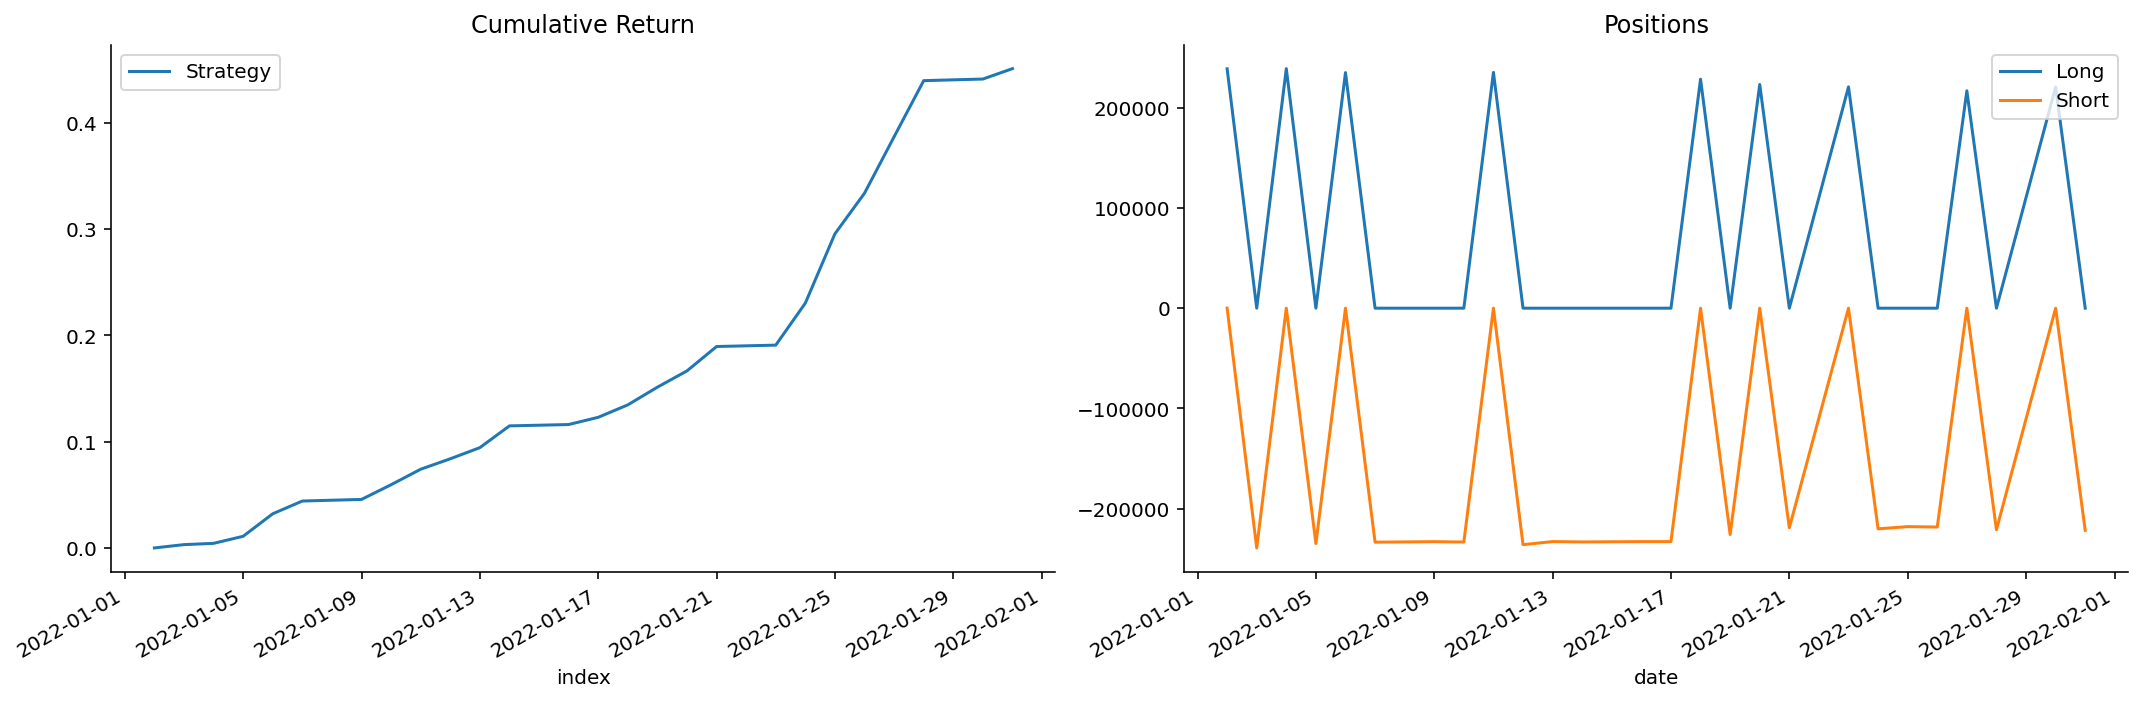

In [9]:
pyfolio_analyzer = backtest_result[0].analyzers.getbyname('pyfolio')
backtest_result, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

backtest_result.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')

returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')

daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy')
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
#positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout()

pf.show_perf_stats(returns)

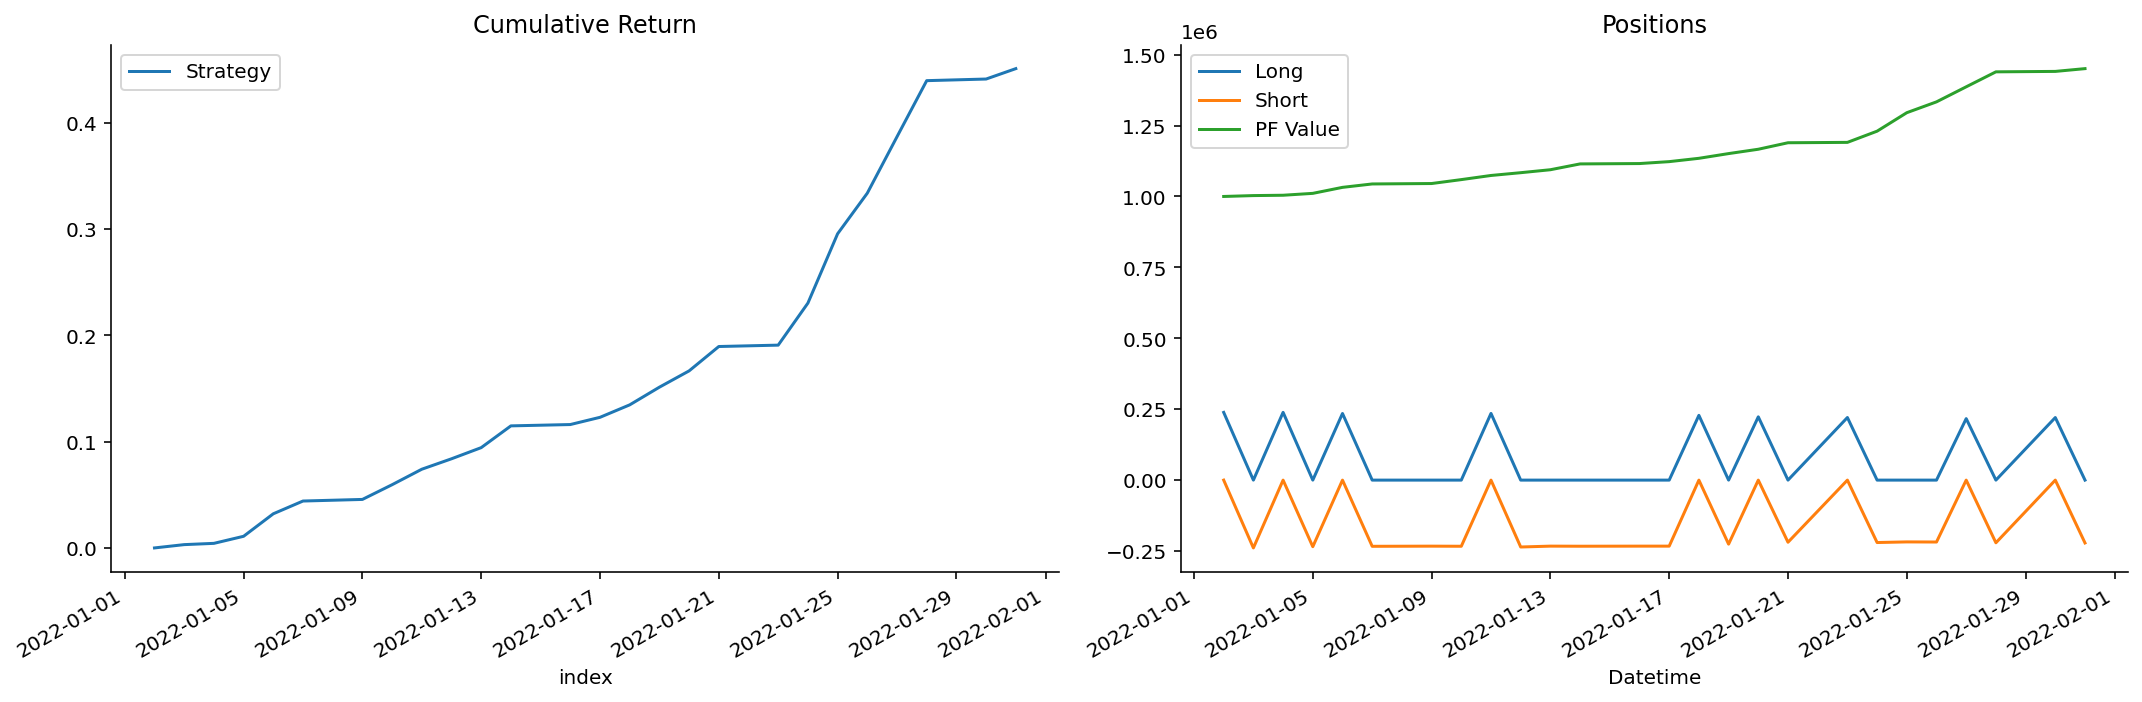

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy')
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout()

In [12]:
pf.show_perf_stats(returns)

/Users/r/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
